In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def gradient(ar):
    grad_i, grad_j = np.gradient(ar)
    return np.array([[(grad_i[i, j], grad_j[i, j]) for j in range(grad_i.shape[1])] for i in range(grad_j.shape[0])])

class PatchedImage():
    def __init__(self, filename, size):
        self.img = plt.imread(filename)
        self.size = size
        self.zone = self.set_zone() # Tout le patch doit etre dans la zone ?
        self.working_patch = (-1,-1)

        self.priorities = None #self.set_priorities()
        self.confidence = None #self.compute_confidence()

        grad_i, grad_j = np.gradient(self.img)
        self.gradient = np.array([[(grad_i[i, j], grad_j[i, j]) for j in range(grad_i.shape[1])] for i in range(grad_j.shape[0])])
    
    def set_zone(self):
        return np.zeros(self.img.shape)
    
    def set_patch_properties(self, coord):
        self.set_confidence_patch(self, coord)
        self.set_data_patch(self, coord)
        

    def set_priorities(self):
        if self.working_patch == (-1, -1):
            for i in range(self.length):
                for j in range(self.width):
                    if self.zone != 0:
                        self.set_confidence_patch(self, (i,j))
                        self.set_data_patch(self, (i,j))
        else:
            k,l = self.working_patch
            self.set_confidence_patch(self, self.working_patch)
            self.set_data_patch(self, self.working_patch)

    def set_confidence_patch(self,coord):
        k,l = coord
        somme = 0
        for i in range(k-self.size,k+self.size+1):
            for j in range(l-self.size,l+self.size+1):
                if self.zone[i,j] == 2:
                    somme += self.confidence[i,j]
        res = somme/(self.size*2+1)**2
        self.confidence[coord] = res
        #return res

    def set_gradient_patch(self, coord):
        k,l = coord
        self.gradient[k-self.size:k+self.size+1,l-self.size:l+self.size+1] = gradient(self.img[k-self.size:k+self.size+1,l-self.size:l+self.size+1])

    def set_data_patch(self,coord):
        i,j = coord
        
        self.set_gradient_patch(coord)

        pat.data = 1
    
    def show_patch(self,coord = None):
        if coord == None:
            coord = self.working_patch

        k,l = coord
        img = self.img[k-self.size:k+self.size+1,l-self.size:l+self.size+1]
        plt.imshow(img, cmap='gray')
        plt.show()


In [ ]:
# Question
# Frontiere fine ou large ? overlap des patchs avec la zone cible
# Calcul du gradient ? Approximation lineaire sur la frontiere ?
# Idem pour le vecteur normal
# Collage des patchs, ecrasement des pixels de la frontiere ou juste sur la target zone

# gradient discret ? methode de calcul au bord et quelle "portée"
# comment stocker les priorities pour optimiser la vitesse de l'algorithme

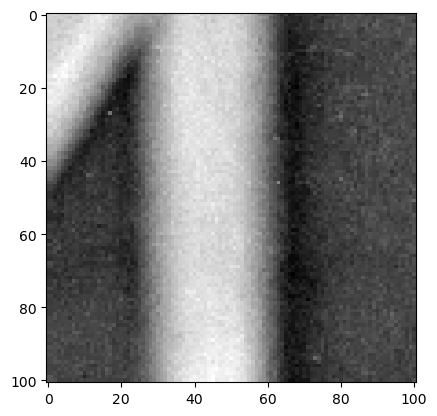

In [20]:
# Exemple d'utilisation
patch_instance = PatchedImage("images/lena.tif",50)

patch_instance.show_patch((100,50))